In [1]:
import pickle
import sys

from sklearn.model_selection import train_test_split

from src.utils import augmentation_random_cut

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import warnings

warnings.simplefilter('ignore')

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from IPython.display import display, HTML

from src.plot_utils import plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, _get_gauss_stats, plot_diff_hist_stats
from src.models import optimal_model_builder


In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [4]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Utils

In [5]:
def plot_difference_hist(y_true, y_pred, channel, method, hist_range=(-2, 2), n_bins=100, return_gauss_stats=True):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'',
                                   plot_gauss=True, return_gauss_stats=return_gauss_stats)

    plt.title(f'{method}. channel={channel}, mean={mu:0.3f}, std={std:0.3f}')
    return std


def train_model(model, X_train, y_train, X_test, y_test, lr=0.01, name='model', train=False, n_epochs=3000, verbose=1,
                batch_size=2048, lr_patience=10, es_patience=200, loss_weights=10_000):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_data_dir = f'/data/model_weights/nn_results/channel_experiments/{name}'
    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=PWD + model_data_dir + "/weights", save_best_only=True,
                                                     save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience, min_delta=0.01))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience=lr_patience))

    try:
        pd.read_csv(PWD + model_data_dir + '/loss_log.csv')
    except:
        train = True

    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                            validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(PWD + model_data_dir + '/loss_log.csv')

    model.load_weights(PWD + model_data_dir + "/weights")
    history = pd.read_csv(PWD + model_data_dir + '/loss_log.csv')

    return history


def load_model(model, lr=0.01, name='model', loss_weights=None):
    model_data_dir = f'/data/model_weights/nn_results/channel_experiments/{name}'
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)
    model.load_weights(PWD + model_data_dir + "/weights")

In [6]:
def pred_and_retrieve_y(model, X):
    Y_heatmap = model.predict(X, batch_size=8192)
    y_pred = np.empty(len(X))
    for i, y in enumerate(Y_heatmap):
        try:
            y_pred[i] = _get_gauss_stats(y, std_0=0.8)
        except:
            print(f'Error calculating {i}')
            y_pred[i] = np.average(np.arange(len(y)), weights=y)
    return y_pred


def compare_model_with_cfd(model, cfd, X, y_true, channel=None, figsize=(12, 4), show=True, y_cfd=None,
                           return_gauss_stats=True, log=True):
    if y_cfd is None:
        y_cfd = np.array([cfd.predict(x) for x in X])
        n_none = list(y_cfd).count(None)
        if n_none > 0:
            print(f'--------------------> CFD returned {n_none} Nones out of {len(y_cfd)} examples')
    y_cfd = y_cfd.astype(np.float64)
    y_model = pred_and_retrieve_y(model, X)

    mask = y_cfd != None
    y_true = y_true[mask]
    y_cfd = y_cfd[mask]
    y_model = y_model[mask]

    if log and channel is not None:
        display(HTML(f'<h4>Channel {channel}</h4>'))

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    std_cfd = plot_difference_hist(y_true, y_cfd, channel, 'CFD', hist_range=(-6, 6), n_bins=300,
                                   return_gauss_stats=return_gauss_stats)
    plt.subplot(1, 2, 2)
    std_model = plot_difference_hist(y_true, y_model, channel, 'NN', hist_range=(-6, 6), n_bins=300,
                                     return_gauss_stats=return_gauss_stats)

    improvement = (std_cfd - std_model) / std_cfd

    if log:
        print(
            f"CFD: {std_cfd:0.3f}, NN: {std_model:0.3f} ({std_cfd * TIME_STEP:0.3f} ns vs {std_model * TIME_STEP:0.3f} ns)")
        print(f'Improvement: {improvement * 100:0.2f} %')
    if show:
        plt.show()
    else:
        plt.close()
    return improvement, std_cfd * TIME_STEP, std_model * TIME_STEP


cfd = CFD(n_baseline=10, fraction=0.25)

In [7]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


_get_gauss_stats(gaussian_kernel(np.array(1.6)))

1.6

## Trained separately, tested on the same channels

In [8]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 16, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    model = optimal_model_builder()
    history = train_model(model, X_train, Y_heatmap_train, X_test, Y_heatmap_test, name=f'model_separate_{channel}',
                          train=False, n_epochs=3000, verbose=0)

    # plot_history(history, f"Channel {channel}, {len(X)} events", ymax=100, figsize=(8, 4))
    improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = improvement, std_model

1/1 [==============================] - 2s 2s/step


CFD: 0.453, NN: 0.390 (0.071 ns vs 0.061 ns)
Improvement: 13.88 %
1/1 [==============================] - 0s 281ms/step


CFD: 0.458, NN: 0.413 (0.072 ns vs 0.065 ns)
Improvement: 9.72 %
1/1 [==============================] - 0s 377ms/step


CFD: 0.407, NN: 0.353 (0.064 ns vs 0.055 ns)
Improvement: 13.34 %
1/1 [==============================] - 0s 259ms/step


CFD: 0.423, NN: 0.357 (0.066 ns vs 0.056 ns)
Improvement: 15.58 %
1/1 [==============================] - 1s 534ms/step
Error calculating 5103


CFD: 0.779, NN: 0.634 (0.122 ns vs 0.099 ns)
Improvement: 18.57 %
1/1 [==============================] - 1s 570ms/step


CFD: 0.751, NN: 0.587 (0.117 ns vs 0.092 ns)
Improvement: 21.81 %
1/1 [==============================] - 0s 490ms/step


CFD: 0.442, NN: 0.342 (0.069 ns vs 0.053 ns)
Improvement: 22.73 %
1/1 [==============================] - 0s 407ms/step


CFD: 0.459, NN: 0.372 (0.072 ns vs 0.058 ns)
Improvement: 18.91 %
1/1 [==============================] - 0s 310ms/step


CFD: 0.441, NN: 0.381 (0.069 ns vs 0.060 ns)
Improvement: 13.71 %
1/1 [==============================] - 0s 278ms/step


CFD: 0.560, NN: 0.485 (0.088 ns vs 0.076 ns)
Improvement: 13.53 %
1/1 [==============================] - 0s 228ms/step


CFD: 0.430, NN: 0.385 (0.067 ns vs 0.060 ns)
Improvement: 10.56 %
1/1 [==============================] - 0s 359ms/step


CFD: 0.427, NN: 0.393 (0.067 ns vs 0.061 ns)
Improvement: 7.98 %
1/1 [==============================] - 0s 272ms/step


CFD: 0.410, NN: 0.364 (0.064 ns vs 0.057 ns)
Improvement: 11.36 %
1/1 [==============================] - 0s 361ms/step


CFD: 0.409, NN: 0.355 (0.064 ns vs 0.056 ns)
Improvement: 13.10 %
2/2 [==============================] - 0s 81ms/step


CFD: 0.598, NN: 0.503 (0.093 ns vs 0.079 ns)
Improvement: 15.78 %
1/1 [==============================] - 1s 645ms/step


CFD: 0.683, NN: 0.604 (0.107 ns vs 0.094 ns)
Improvement: 11.52 %
1/1 [==============================] - 1s 555ms/step


CFD: 0.768, NN: 0.665 (0.120 ns vs 0.104 ns)
Improvement: 13.36 %
2/2 [==============================] - 1s 345ms/step


CFD: 0.709, NN: 0.575 (0.111 ns vs 0.090 ns)
Improvement: 18.83 %
1/1 [==============================] - 1s 555ms/step


CFD: 0.487, NN: 0.386 (0.076 ns vs 0.060 ns)
Improvement: 20.73 %
1/1 [==============================] - 0s 446ms/step


CFD: 0.444, NN: 0.381 (0.069 ns vs 0.060 ns)
Improvement: 14.15 %
1/1 [==============================] - 0s 341ms/step


CFD: 0.468, NN: 0.396 (0.073 ns vs 0.062 ns)
Improvement: 15.38 %
1/1 [==============================] - 0s 377ms/step


CFD: 0.509, NN: 0.429 (0.079 ns vs 0.067 ns)
Improvement: 15.68 %


In [9]:
channels = improvements.keys()
precision_data = [f'{std_model * 1000:0.1f}' for _, std_model in improvements.values()]
improvement_data = [f'{improv * 100:0.0f} %' for improv, _ in improvements.values()]

df = pd.DataFrame({'precision [ps]': precision_data, 'improvement': improvement_data}, index=channels)
df.index.name = 'channel'
df
# df.to_csv('channel_precision_improvements.csv')

,precision [ps],improvement
channel,,
8,60.9,14 %
9,64.6,10 %
10,55.1,13 %
11,55.7,16 %
13,99.1,19 %
14,91.7,22 %
16,53.4,23 %
17,58.1,19 %
18,59.5,14 %


## Trained separately, tested separately

In [10]:
# results = defaultdict(dict)
# for model_channel in list(all_channels_data.keys()):
#     print(f'Processing channel {model_channel}...')
#     model = optimal_model_builder()
#     load_model(model, lr=0.001, name=f'model_separate_{model_channel}', loss_weights=100)
#
#     for channel, (X, y) in list(all_channels_data.items()):
#         X_aug, y_aug = augmentation_random_cut(X, y, 16, seed=42, apply=True)
#         _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#         Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
#
#         try:
#             improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False, log=False)
#         except RuntimeError:
#             improvement = float('nan')
#             std_model = float('nan')
#         results[model_channel][channel] = (improvement, std_model)
#
# with open(PWD + '/data/nn_results/channel_experiments/multi_channel_separate_results.pkl', 'wb') as file:
#     pickle.dump(results, file)

In [11]:
with open(PWD + '/data/nn_results/channel_experiments/multi_channel_separate_results.pkl', 'rb') as file:
    results = pickle.load(file)

# Check that the order is the same
assert list(results.keys()) == sorted(results.keys())
for x in results.values():
    assert list(x.keys()) == sorted(x.keys())

row_names = [str(key) for key in results.keys()]
col_names = [str(key) for key in list(results.values())[0].keys()]

In [12]:
improv_data = np.array([list(f'{std * 1000:0.1f} ps' for x, std in r.values()) for r in results.values()])

df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on \ tested on'
with pd.option_context('display.max_columns', None):
    display(df)

,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
trained on \ tested on,,,,,,,,,,,,,,,,,,,,,,
8,60.9 ps,70.7 ps,63.7 ps,61.8 ps,157.7 ps,144.0 ps,69.4 ps,77.8 ps,69.4 ps,109.9 ps,63.5 ps,69.9 ps,62.0 ps,62.5 ps,164.0 ps,182.2 ps,179.1 ps,131.7 ps,86.5 ps,71.6 ps,81.7 ps,81.3 ps
9,60.4 ps,64.6 ps,57.5 ps,59.7 ps,140.4 ps,122.3 ps,66.0 ps,66.3 ps,68.6 ps,86.1 ps,65.3 ps,63.3 ps,61.1 ps,61.1 ps,104.0 ps,118.8 ps,129.2 ps,119.9 ps,73.1 ps,69.3 ps,77.1 ps,83.9 ps
10,64.0 ps,68.5 ps,55.1 ps,58.0 ps,127.3 ps,121.9 ps,62.4 ps,62.6 ps,66.0 ps,84.4 ps,64.1 ps,63.1 ps,59.9 ps,58.3 ps,99.6 ps,108.1 ps,136.5 ps,136.6 ps,69.9 ps,67.1 ps,74.7 ps,84.8 ps
11,65.3 ps,67.4 ps,57.5 ps,55.7 ps,156.8 ps,136.8 ps,57.7 ps,67.4 ps,65.4 ps,101.1 ps,64.7 ps,64.6 ps,57.6 ps,56.6 ps,126.4 ps,135.6 ps,146.3 ps,130.7 ps,71.3 ps,65.7 ps,74.0 ps,77.5 ps
13,75.3 ps,73.0 ps,68.9 ps,68.3 ps,99.1 ps,96.8 ps,73.1 ps,78.5 ps,76.6 ps,92.3 ps,76.1 ps,74.9 ps,68.3 ps,66.5 ps,90.2 ps,97.8 ps,106.9 ps,102.7 ps,83.8 ps,70.8 ps,85.8 ps,98.2 ps
14,71.1 ps,71.6 ps,64.1 ps,70.8 ps,101.4 ps,91.7 ps,71.8 ps,69.6 ps,73.2 ps,85.7 ps,67.5 ps,72.4 ps,65.2 ps,63.2 ps,88.0 ps,98.2 ps,105.0 ps,96.9 ps,73.5 ps,66.0 ps,78.1 ps,74.0 ps
16,65.4 ps,70.2 ps,59.9 ps,57.0 ps,162.1 ps,138.8 ps,53.4 ps,60.5 ps,64.0 ps,87.7 ps,65.4 ps,65.6 ps,58.2 ps,56.8 ps,118.4 ps,130.7 ps,168.6 ps,120.2 ps,65.4 ps,63.7 ps,66.3 ps,77.4 ps
17,70.5 ps,73.4 ps,58.9 ps,60.0 ps,133.5 ps,113.7 ps,57.4 ps,58.1 ps,64.3 ps,83.1 ps,72.7 ps,68.1 ps,58.4 ps,59.5 ps,91.4 ps,109.7 ps,122.8 ps,102.2 ps,62.3 ps,63.8 ps,66.5 ps,84.2 ps
18,67.0 ps,69.2 ps,60.6 ps,61.2 ps,104.9 ps,99.8 ps,58.4 ps,62.7 ps,59.5 ps,80.7 ps,65.8 ps,64.2 ps,58.4 ps,59.5 ps,97.9 ps,100.8 ps,111.8 ps,106.9 ps,68.0 ps,60.9 ps,64.6 ps,70.3 ps


In [13]:
improv_data = np.array([list(f'{x * 100:0.0f} %' for x, std in r.values()) for r in results.values()])

df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on \ tested on'
with pd.option_context('display.max_columns', None):
    display(df)

,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
trained on \ tested on,,,,,,,,,,,,,,,,,,,,,,
8,14 %,1 %,-0 %,6 %,-30 %,-23 %,-1 %,-9 %,-1 %,-26 %,6 %,-5 %,3 %,2 %,-76 %,-71 %,-49 %,-19 %,-14 %,-3 %,-12 %,-2 %
9,15 %,10 %,10 %,10 %,-15 %,-4 %,4 %,7 %,1 %,2 %,3 %,5 %,5 %,4 %,-11 %,-11 %,-8 %,-8 %,4 %,0 %,-5 %,-6 %
10,10 %,4 %,13 %,12 %,-5 %,-4 %,10 %,13 %,4 %,4 %,5 %,5 %,7 %,9 %,-7 %,-1 %,-14 %,-23 %,8 %,3 %,-2 %,-7 %
11,8 %,6 %,10 %,16 %,-29 %,-17 %,16 %,6 %,5 %,-15 %,4 %,3 %,10 %,11 %,-35 %,-27 %,-22 %,-18 %,6 %,5 %,-1 %,2 %
13,-6 %,-2 %,-8 %,-3 %,19 %,18 %,-6 %,-9 %,-11 %,-5 %,-13 %,-12 %,-7 %,-4 %,3 %,8 %,11 %,7 %,-10 %,-2 %,-17 %,-24 %
14,-0 %,-0 %,-1 %,-7 %,17 %,22 %,-4 %,3 %,-6 %,2 %,-1 %,-9 %,-2 %,1 %,6 %,8 %,13 %,13 %,3 %,5 %,-7 %,7 %
16,8 %,2 %,6 %,14 %,-33 %,-18 %,23 %,16 %,7 %,-0 %,3 %,2 %,9 %,11 %,-27 %,-22 %,-41 %,-9 %,14 %,8 %,9 %,3 %
17,0 %,-3 %,7 %,9 %,-10 %,3 %,17 %,19 %,7 %,5 %,-8 %,-2 %,9 %,7 %,2 %,-3 %,-2 %,8 %,18 %,8 %,9 %,-6 %
18,5 %,3 %,5 %,7 %,14 %,15 %,15 %,12 %,14 %,8 %,2 %,4 %,9 %,7 %,-5 %,6 %,7 %,4 %,11 %,12 %,12 %,12 %


## Trained on all the channels, tested on separate channels

In [14]:
X_all_train, X_all_test, y_all_train, y_all_test = [], [], [], []

for X, y in list(all_channels_data.values()):
    X_aug, y_aug = augmentation_random_cut(X, y, 16, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    X_all_train.append(X_train)
    X_all_test.append(X_test)
    y_all_train.append(y_train)
    y_all_test.append(y_test)

X_all_train = np.concatenate(X_all_train)
X_all_test = np.concatenate(X_all_test)
y_all_train = np.concatenate(y_all_train)
y_all_test = np.concatenate(y_all_test)

Y_all_heatmap_train = np.array([gaussian_kernel(y) for y in y_all_train])
Y_all_heatmap_test = np.array([gaussian_kernel(y) for y in y_all_test])

X_all_train.shape, X_all_test.shape, y_all_train.shape, y_all_test.shape

((416976, 48), (104257, 48), (416976,), (104257,))

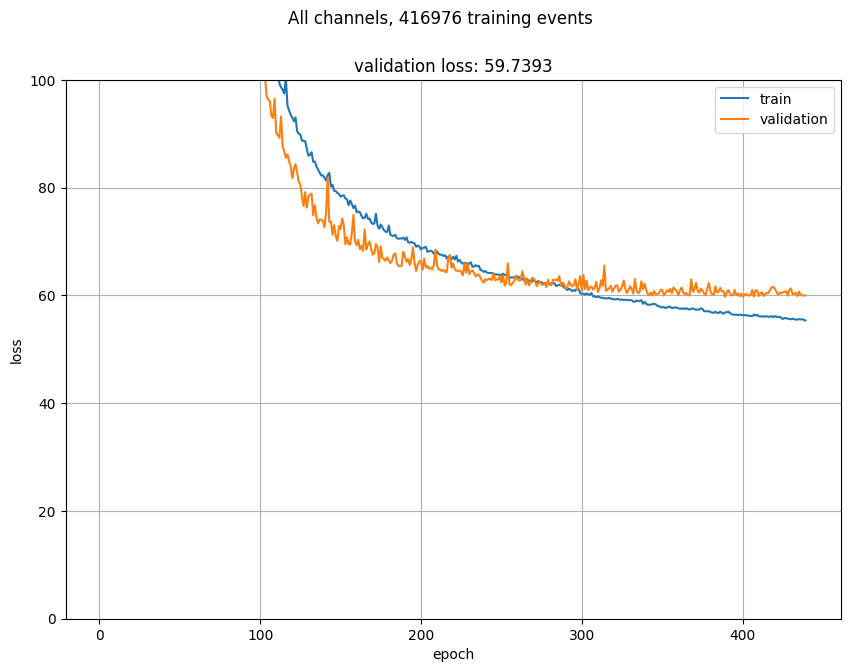

In [15]:
model = optimal_model_builder()

history = train_model(model, X_all_train, Y_all_heatmap_train, X_all_test, Y_all_heatmap_test,
                      name=f'model_all_channels', batch_size=8192, train=False, n_epochs=500, verbose=1,
                      lr_patience=4, es_patience=50)

plot_history(history, f"All channels, {len(X_all_train)} training events", ymax=100, figsize=(10, 7))

In [16]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 16, seed=42, apply=True)
    _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = (improvement, std_model)

1/1 [==============================] - 0s 237ms/step


CFD: 0.453, NN: 0.471 (0.071 ns vs 0.074 ns)
Improvement: -4.12 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.458, NN: 0.432 (0.072 ns vs 0.068 ns)
Improvement: 5.62 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.407, NN: 0.375 (0.064 ns vs 0.059 ns)
Improvement: 7.81 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.423, NN: 0.368 (0.066 ns vs 0.058 ns)
Improvement: 12.86 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.779, NN: 0.681 (0.122 ns vs 0.106 ns)
Improvement: 12.62 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.751, NN: 0.647 (0.117 ns vs 0.101 ns)
Improvement: 13.88 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.442, NN: 0.346 (0.069 ns vs 0.054 ns)
Improvement: 21.65 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.459, NN: 0.395 (0.072 ns vs 0.062 ns)
Improvement: 13.89 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.441, NN: 0.380 (0.069 ns vs 0.059 ns)
Improvement: 13.80 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.560, NN: 0.519 (0.088 ns vs 0.081 ns)
Improvement: 7.46 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.430, NN: 0.422 (0.067 ns vs 0.066 ns)
Improvement: 1.96 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.427, NN: 0.404 (0.067 ns vs 0.063 ns)
Improvement: 5.50 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.410, NN: 0.362 (0.064 ns vs 0.057 ns)
Improvement: 11.74 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.409, NN: 0.374 (0.064 ns vs 0.058 ns)
Improvement: 8.61 %
2/2 [==============================] - 0s 82ms/step


CFD: 0.598, NN: 0.525 (0.093 ns vs 0.082 ns)
Improvement: 12.26 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.683, NN: 0.618 (0.107 ns vs 0.097 ns)
Improvement: 9.47 %
1/1 [==============================] - 0s 12ms/step
Error calculating 5993


CFD: 0.768, NN: 0.708 (0.120 ns vs 0.111 ns)
Improvement: 7.79 %
2/2 [==============================] - 0s 163ms/step


CFD: 0.709, NN: 0.592 (0.111 ns vs 0.092 ns)
Improvement: 16.55 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.487, NN: 0.378 (0.076 ns vs 0.059 ns)
Improvement: 22.42 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.444, NN: 0.394 (0.069 ns vs 0.062 ns)
Improvement: 11.20 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.468, NN: 0.400 (0.073 ns vs 0.063 ns)
Improvement: 14.52 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.509, NN: 0.440 (0.079 ns vs 0.069 ns)
Improvement: 13.57 %


In [17]:
channels = improvements.keys()
precision_data = [f'{std_model * 1000:0.1f}' for _, std_model in improvements.values()]
improvement_data = [f'{improv * 100:0.0f} %' for improv, _ in improvements.values()]

df = pd.DataFrame({'precision [ps]': precision_data, 'improvement': improvement_data}, index=channels)
df.index.name = 'channel'
df

,precision [ps],improvement
channel,,
8,73.7,-4 %
9,67.5,6 %
10,58.6,8 %
11,57.5,13 %
13,106.4,13 %
14,101.1,14 %
16,54.1,22 %
17,61.7,14 %
18,59.5,14 %
